# DAT200 CA3 2022

Kaggle username: catya0429(JisooPark)

### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# data propressessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# modeling
from sklearn.ensemble import RandomForestClassifier # Random Forest

### Reading data

Data description

    NSWprice: New South Wales electricity price, normalized values between 0 and 1
    NSWdemand: New South Wales electricity demand, normalized values  between 0 and 1
    VICprice: Victoria electricity price, normalized values  between 0 and 1
    VICdemand: Victoria electricity demand, normalized values  between 0 and 1
    transfer: scheduled electricity transfer between both states, normalized values  between 0 and 1

    Target: 0 (price decreases), 1 (price increases)
 
    Note: Due to the power corruption, not all data might be in the range (0, 1)

In [2]:
# Load the data
path = %pwd

train = pd.read_csv(path + "\\data\\train.csv", index_col = 0)
test = pd.read_csv(path + "\\data\\test.csv", index_col = 0)

print(train.shape)
print(test.shape)

(33994, 6)
(11328, 5)


### Data exploration and visualisation

In [3]:
train.info() # brief info of the raw data
# train.isnull().sum() # count the null data if any

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33994 entries, 0 to 33993
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   nswprice   33994 non-null  float64
 1   nswdemand  33994 non-null  float64
 2   vicprice   33994 non-null  float64
 3   vicdemand  33994 non-null  float64
 4   transfer   33994 non-null  float64
 5   target     33994 non-null  int64  
dtypes: float64(5), int64(1)
memory usage: 1.8 MB


In [4]:
print(train['target'].value_counts() )
print("ratio of y: \n", train['target'].value_counts() /len(train))

0    19560
1    14434
Name: target, dtype: int64
ratio of y: 
 0    0.575396
1    0.424604
Name: target, dtype: float64


In [5]:
# Describe of X variables
train.iloc[:, :-1].describe()

,nswprice,nswdemand,vicprice,vicdemand,transfer
count,33994.000000,33994.000000,33994.000000,33994.000000,33994.000000
mean,0.057260,0.422004,0.003422,0.418636,0.496951
std,0.052392,0.319866,0.010215,0.293709,0.288964
min,-3.354880,-20.103552,-0.229600,-17.996896,-19.382464
25%,0.035127,0.310213,0.002277,0.373123,0.414912
50%,0.048667,0.444808,0.003467,0.422915,0.414912
75%,0.074306,0.537303,0.003467,0.468863,0.605702
max,0.979975,0.980809,1.000000,1.000000,1.000000


In [6]:
test.describe()

,nswprice,nswdemand,vicprice,vicdemand,transfer
count,11328.000000,11328.000000,11328.000000,11328.000000,11328.000000
mean,0.057994,0.421899,0.003490,0.422103,0.499075
std,0.042773,0.163896,0.010962,0.122004,0.153778
min,0.000000,0.001488,0.000000,0.029518,0.006579
25%,0.035060,0.305378,0.002270,0.368980,0.414912
50%,0.048562,0.440345,0.003467,0.422915,0.414912
75%,0.074404,0.532170,0.003467,0.470223,0.605702
max,1.000000,1.000000,0.996228,0.996893,0.943860


In [7]:
# Extreme outlier can be defined when nswdemand below zero
train[(train.nswdemand <0)]

,nswprice,nswdemand,vicprice,vicdemand,transfer,target
index,,,,,,
1883,-2.029056,-9.901824,-0.110944,-13.533280,-13.277184,1
2501,-1.212448,-10.106528,-0.082752,-11.591936,-13.866656,1
5615,-1.322912,-20.103552,-0.087552,-14.798560,-18.343872,1
6044,-3.354880,-17.651904,-0.229600,-17.822880,-8.505248,0
9310,-2.797632,-16.718848,-0.186112,-17.549472,-13.614048,1
11593,-1.517952,-15.876224,-0.110944,-13.533280,-13.277184,1
16156,-1.804256,-19.870272,-0.125504,-17.996896,-6.161408,0
18200,-1.935872,-10.187456,-0.110944,-13.533280,-13.277184,1
24771,-1.203808,-17.723296,-0.080288,-16.555168,-19.382464,0


In the train data set, there are some data that is smaller than zero. This is because the power corruption as written in data description. Thus, we would treat it as an outlier and consider to delete from the train data set.

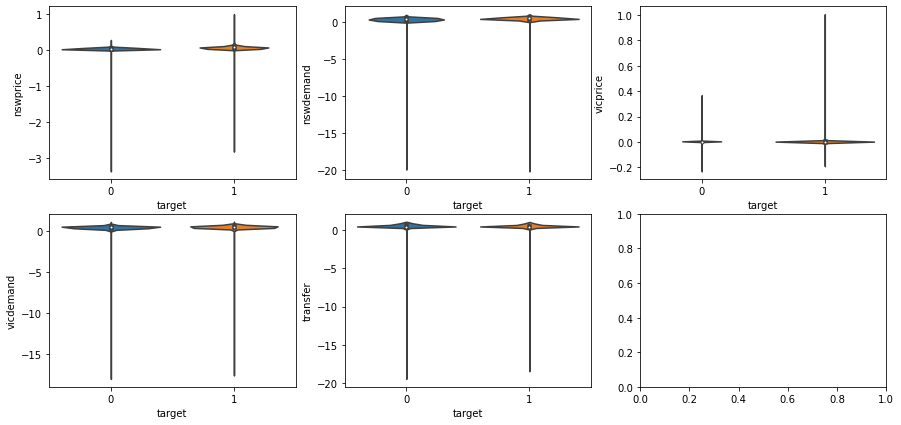

In [8]:
# Original data distribution by columns
fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize = (15, 7))
for i, col_name in enumerate(train.iloc[:, :-1]):
    row = i // 3
    col = i % 3
    if row in range(0, 2):
        sns.violinplot(data = train, x = 'target', y = col_name, ax = axes[row][col])
plt.show()

<Figure size 1080x504 with 0 Axes>

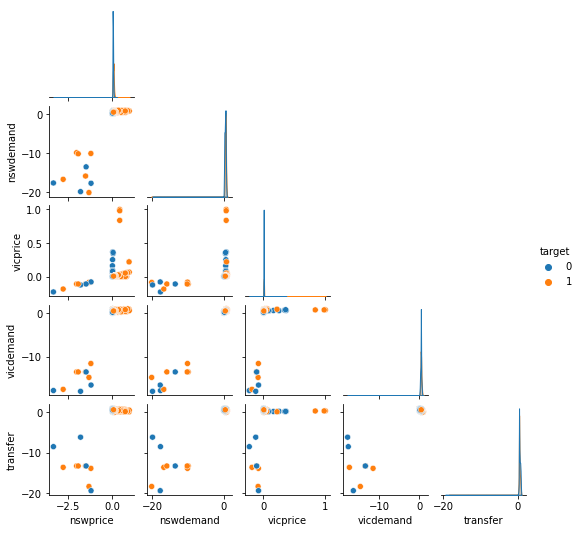

In [9]:
plt.figure(figsize = (15, 7))
sns.pairplot(train, hue = 'target', height=1.5, corner=True)
plt.show()

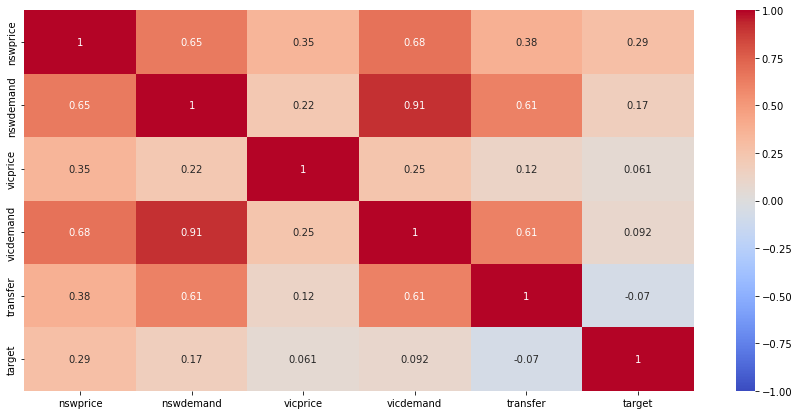

In [10]:
plt.figure(figsize = (15, 7))
sns.heatmap(train.corr(), annot = True, vmax = 1, vmin = -1, cmap = 'coolwarm')
plt.show()

### Data cleaning

In [11]:
# Summarizing X variables
# X = pd.concat([train.iloc[:, 0:5], test])
print("Train: ", train.shape, "/ Test: ", test.shape)
# print("Total: ", X.shape)

Train:  (33994, 6) / Test:  (11328, 5)


In [12]:
# Define Outliers as nswdemand < 0, nswprice < 0.2, vicprice < 0.01
# X = train[(train.nswdemand > 0)]
X = train.copy()
X = X[(X.nswdemand > 0) & (X.vicprice < 0.01) & (X.nswprice < 0.2)]
print("After delete outliers: ", X.shape)
print("Elimination proportion: ", round((train.shape[0] - X.shape[0])/train.shape[0], 3))

After delete outliers:  (33652, 6)
Elimination proportion:  0.01


In [13]:
X.describe()
# X.iloc[:, :]

,nswprice,nswdemand,vicprice,vicdemand,transfer,target
count,33652.000000,33652.000000,33652.000000,33652.000000,33652.000000,33652.000000
mean,0.055666,0.424399,0.003204,0.421536,0.501657,0.419559
std,0.025946,0.161814,0.001276,0.118994,0.152897,0.493494
min,0.000000,0.001190,0.000000,0.000000,0.000000,0.000000
25%,0.034977,0.308688,0.002270,0.371828,0.414912,0.000000
50%,0.048397,0.443023,0.003467,0.422915,0.414912,0.000000
75%,0.073346,0.535406,0.003467,0.465303,0.606579,1.000000
max,0.197760,0.948974,0.009994,0.952356,1.000000,1.000000


### Data exploration after cleaning

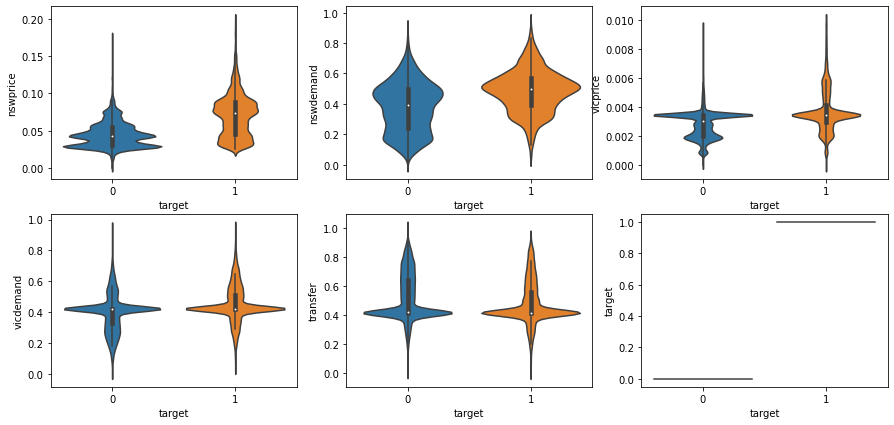

In [14]:
fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize = (15, 7))
for i, col_name in enumerate(X):
    row = i // 3
    col = i % 3
    if row in range(0, 2):
        sns.violinplot(data = X, x = 'target', y = col_name, ax = axes[row][col])
plt.show()

<Figure size 1080x504 with 0 Axes>

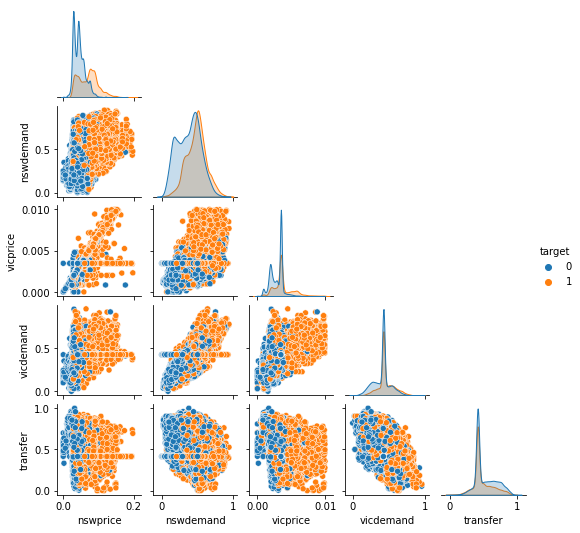

In [15]:
plt.figure(figsize = (15, 7))
sns.pairplot(X, hue = 'target', height=1.5, corner=True)
plt.show()

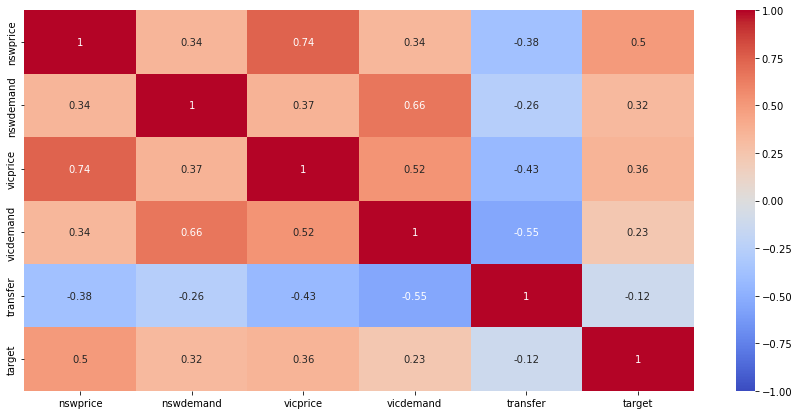

In [16]:
plt.figure(figsize = (15, 7))
sns.heatmap(X.corr(), annot = True, vmax = 1, vmin = -1, cmap = 'coolwarm')
plt.show()

Since we excluded the outliers by three conditions; `(train.nswdemand > 0)` , `(train.vicprice < 0.01)` and `(train.nswprice < 0.2)`, we can see the clear differences prior to and post of deleting the data. There is still a high positive correlation between two price variables(nswprice, vicprice) and between two demands variables(nwsdemand, vicdemand). It may imply those variables have multicollinearity that affects target variable prediction.
There are clear mean differences in `nswprice`, `nswdemand` variables by the `target`, the model would learn these differences in the data so those two variables would be an important variables.

### Data preprocessing

In [17]:
# Split into X variables and y
y = X.iloc[:, 5].values
X = X.iloc[:, :-1]

In [18]:
print("Shape of X: ", X.shape, "/ Shape of y: ", y.shape)

Shape of X:  (33652, 5) / Shape of y:  (33652,)


#### Train test split

In [19]:
# Sub split using train data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1, stratify = y)
print('X_train: ', X_train.shape, '/ X_test: ', X_test.shape)
print('y_train: ', y_train.shape, '  / y_test: ', y_test.shape)


X_train:  (23556, 5) / X_test:  (10096, 5)
y_train:  (23556,)   / y_test:  (10096,)


#### Scaling

Scaling is not necessary because the given data set is already normalized. 

### Modelling

In [20]:
# n_estimator & max_features
tmp1 = [] # 
for i in range(2, 6):
    for j in range(10, 160, 10):
        # fit RandomForest
        rf = RandomForestClassifier(criterion='gini',
                            n_estimators = j,
                            max_features= i,
                            random_state = 429,
                            n_jobs = -1).fit(X_train, y_train)
        # predict the class
        rf_y_pred = rf.predict(X_test)
        # number of correct classification
        num_correct = (rf_y_pred == y_test).sum()
        # calculate the accuracy 
        accuracy = round(num_correct / X_test.shape[0], 3)
        # Append results 
        tmp1.append([i, j, num_correct, accuracy])

# Assign to dataframe        
rf_res = pd.DataFrame(tmp1, columns =['max_features', 'n_estimators', 'num_correct', 'accuracy'])
rf_res.pivot_table(index = 'n_estimators', columns = 'max_features', values = 'accuracy')

max_features,2,3,4,5
n_estimators,,,,
10,0.785,0.782,0.784,0.787
20,0.788,0.792,0.788,0.790
30,0.791,0.793,0.791,0.790
40,0.793,0.794,0.792,0.793
50,0.791,0.794,0.795,0.794
60,0.794,0.795,0.796,0.793
70,0.793,0.794,0.796,0.794
80,0.794,0.795,0.795,0.794
90,0.794,0.796,0.795,0.795


In [21]:
print("maximum  accuracy: ")
print(rf_res.loc[rf_res['accuracy'].idxmax()])

maximum  accuracy: 
max_features       2.000
n_estimators     130.000
num_correct     8043.000
accuracy           0.797
Name: 12, dtype: float64


If other conditions are under controlled status, then `max_feature = 2` and `n_estimators = 30` can be considered as a best parameters.

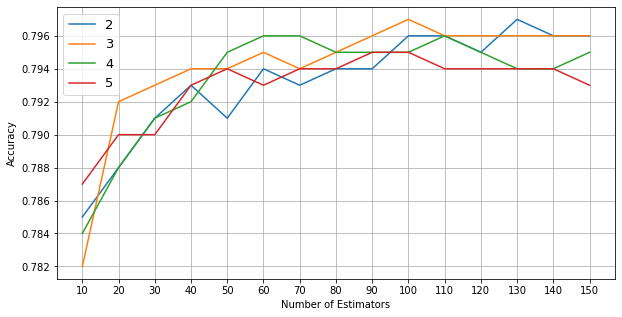

In [22]:
plt.figure(figsize = (10, 5))
xticks = [f'{i} ' for i in range(10, 160, 10)]
for num in [2, 3, 4, 5]:
    d_ = rf_res[(rf_res["max_features"] == num)]
    plt.plot(d_["n_estimators"], d_["accuracy"], 
             label = str(num))
plt.grid()
plt.legend(fontsize = 13)
plt.xticks(range(10, 160, 10), range(10, 160, 10))
plt.xlabel("Number of Estimators")
plt.ylabel("Accuracy")
plt.show()

In [23]:
# Final Random Forest
rf = RandomForestClassifier(criterion='gini',
                            n_estimators = 130,
                            max_features= 2,
                            random_state = 429,
                            n_jobs = -1)
rf.fit(X, y)

RandomForestClassifier(max_features=2, n_estimators=130, n_jobs=-1,
                       random_state=429)

### Evaluation

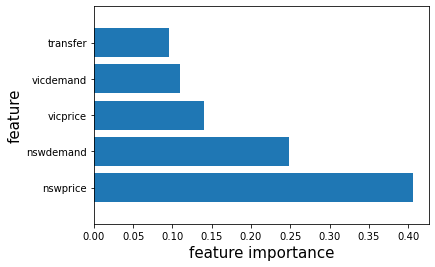

In [24]:
# Caculate feature importance

n_feature = X_train.shape[1]
index = np.arange(n_feature)

plt.barh(index, rf.feature_importances_, align='center')
plt.yticks(index, X_train.columns[index])
plt.ylim(-1, n_feature)
plt.xlabel('feature importance', size=15)
plt.ylabel('feature', size=15)
plt.show()

`nswprice` and `nswdemand` show the highest feature importance value in the Random Forest model. However, this is a relative value based on the model's criterion and other constraints. 

In [25]:
rf_te_pred = rf.predict(test)
rf_te_pred = pd.DataFrame(rf_te_pred)
print(rf_te_pred.value_counts()/len(rf_te_pred))
print(train['target'].value_counts()/len(train))

0    0.610876
1    0.389124
dtype: float64
0    0.575396
1    0.424604
Name: target, dtype: float64


In [26]:
rf_te_pred.columns = ['target']
rf_te_pred = rf_te_pred.rename_axis('index').reset_index()
rf_te_pred.head()

,index,target
0,0,0
1,1,1
2,2,1
3,3,0
4,4,1


In [27]:
# Data Export
rf_te_pred.to_csv('rf_pred.csv',
                  float_format = '%.2f',
                 index=False)

### Kaggle submission

Final score: 0.80035